<h1>Лабораторная работа 1</h1>
Енгоян Сергей А-01м-25<br>
Визуальный анализ временного ряда и обработка аномальных измерений.<br> 
Непараметрические и параметрические методы обнаружения и выделения <br>
компонент временного ряда, анализ случайности и стационарности временных рядов.

In [113]:
import numpy as np
import matplotlib.pyplot as plt

<h3>1) Моделирование временного ряда</h3>

In [114]:
def time_series(t, N, num=1):
    e = np.random.normal(loc=0, scale=1, size=N)
    a0 = np.random.uniform(0.1, 0.5)
    a1 = np.random.uniform(0.01, 0.1)       #По условию от 0.01 до 0.1 что слишком мало для анализа
    a2 = np.random.uniform(0.5, 1.0)    #По условию от 0.5 до 1.0 что слишком много для анализа

    result = []
    if num == 1:
        for i in range(N):
            result.append(a0 * np.sin(a1 * 2 * np.pi * t[i]) + a2 * e[i])
        print('A =', a0, 'f =', a1, 'a2 =', a2)
        return result
    elif num == 2:
        for i in range(N):
            result.append(abs(e[i]) ** (0.1 * t[i]) + 2 * np.e)
        return result

A = 0.30970120291372105 f = 0.09649082204962556 a2 = 0.9389581687335775


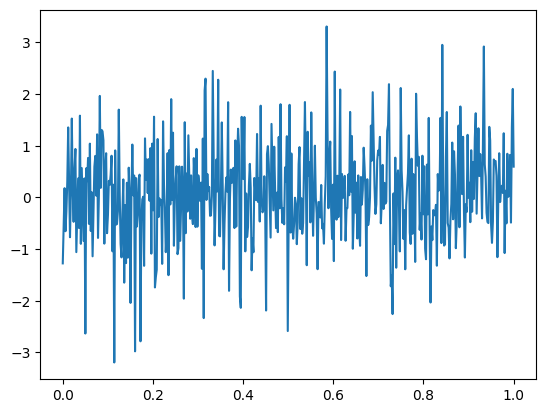

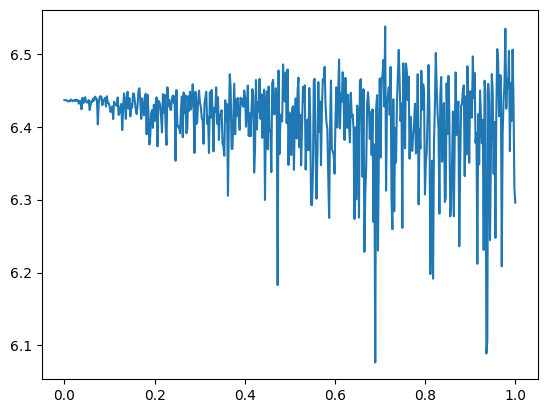

In [115]:
N = 500        # Количество точек
T = 1           # Время моделирования

t = np.linspace(0, T, N)

y1 = time_series(t, N, num=1)
y2 = time_series(t, N, num=2)

plt.plot(t, y1)
plt.show()
plt.plot(t, y2)
plt.show()

<h3>2) Анализ аномалий с помощью эллипса рассеяния</h3>

In [116]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

In [117]:
def diffs(X):
    X = np.array(X, dtype=float)
    N = len(X)

    diff_x = np.full(N, np.nan)  # разница с предыдущим
    diff_y = np.full(N, np.nan)  # разница с следующим

    # начиная со второго элемента до последнего, считаем разницу с предыдущим
    diff_x[1:-1] = X[1:-1] - X[0:-2]

    # начиная со второго до предпоследнего, считаем разницу с следующим
    diff_y[1:-1] = X[2:] - X[1:-1]

    return diff_x, diff_y 

In [118]:
def ellips(Y, PARAM):
    dx, dy = diffs(Y)

    # Очистка от NaN
    mask = ~np.isnan(dx) & ~np.isnan(dy)
    dx_clean = dx[mask]
    dy_clean = dy[mask]

    # Середина эллипса
    mean_x = np.mean(dx_clean)
    mean_y = np.mean(dy_clean)

    # Ковариационная матрица
    cov = np.cov(dx_clean, dy_clean)

    # Главные оси
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Размеры эллипса
    confidence_val = chi2.ppf(PARAM, df=2)
    width, heigth = 2 * np.sqrt(confidence_val * vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    el = Ellipse(
        xy=(mean_x, mean_y),
        width=width,
        height=heigth,
        angle=angle,
        edgecolor='r',
        facecolor='none',
        lw=2
    )

    # Махаланобисово расстояние
    inv_cov = np.linalg.inv(cov)
    diffs_array = np.vstack([dx_clean - mean_x, dy_clean - mean_y]).T
    mahal_sq = np.sum(diffs_array @ inv_cov * diffs_array, axis=1)

    # Отбор аномалий
    in_quadrant = ((dx_clean < 0) & (dy_clean > 0)) | ((dx_clean > 0) & (dy_clean < 0))
    outliers_mask = (mahal_sq > confidence_val) & in_quadrant

    # Координаты и индексы аномалий
    outlier_x = dx_clean[outliers_mask]
    outlier_y = dy_clean[outliers_mask]
    outlier_indices = np.where(mask)[0][outliers_mask]

    # Запись аномалий
    anomalies = []
    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        anomalies.append(idx)
        # print(f"{idx} : {Y[idx]} {x} {y}")

    fig, ax = plt.subplots()
    ax.spines['left'].set_position(('data', mean_x))
    ax.spines['bottom'].set_position(('data', mean_y))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.scatter(dx_clean, dy_clean, s=10, label='Точки')
    ax.scatter(outlier_x, outlier_y, color='orange', s=30, label='Аномалии')

    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        ax.annotate(str(idx), (x, y), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)

    ax.add_patch(el)
    ax.legend()
    plt.show()

    return anomalies

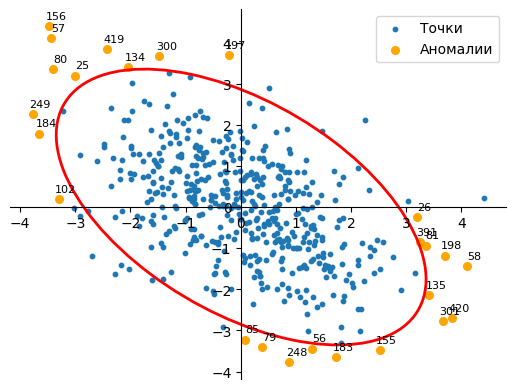

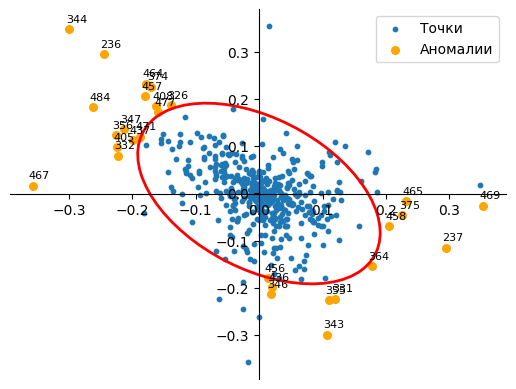

In [119]:
PARAM = 0.95

anom_y1 = ellips(y1, PARAM)

anom_y2 = ellips(y2, PARAM)

In [120]:
def smoothing(Y, anomalies):
    X = Y.copy()
    for i in anomalies:
        if i == 0:
            X[i] = (X[i+1] + X[i+2]) / 2
        elif i == len(X) - 1:
            X[i] = (X[i-1] + X[i-2]) / 2
        else:
            X[i] = (X[i-1] + X[i+1]) / 2
    return X

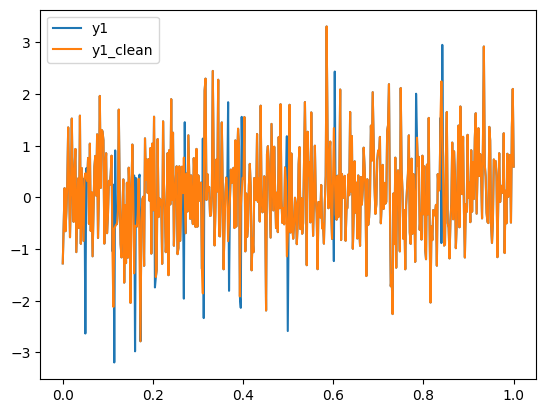

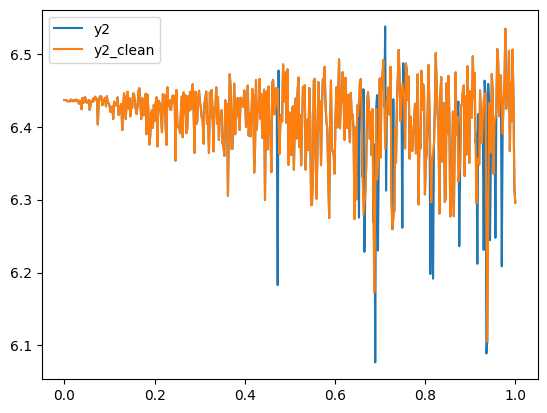

In [121]:
y1_clean = smoothing(y1, anom_y1)
y2_clean = smoothing(y2, anom_y2)

plt.plot(t, y1, label='y1')
plt.plot(t, y1_clean, label='y1_clean')
plt.legend()
plt.show()
plt.plot(t, y2, label='y2')
plt.plot(t, y2_clean, label='y2_clean')
plt.legend()
plt.show()

<h3>3) Исследование стационарности</h3>

In [122]:
def nums_max_series(X):
    # Нахождение кол-ва последовательностей и максимальной длины
    series, max_series = 1, 0
    current_length = 1

    for i in range(1, len(X)):
        if X[i] == X[i-1]:
            current_length += 1
        else:
            max_series = max(max_series, current_length)
            series += 1
            current_length = 1
    return series, max(max_series, current_length)

In [123]:
def up_down_test(X, n):
    # Up&Down тест для выборки X длины n
    up_down = []

    for i in range(0, len(X)-1):
        if X[i+1] - X[i] > 0:
            up_down.append("+")
        elif X[i+1] - X[i] < 0:
            up_down.append("-")
        else:
            continue
    
    series, max_series = nums_max_series(up_down)
    
    nu = (2 * n) / 3 - 1.96 * np.sqrt((16*n - 29) / 90)
    tau = 6

    # print(nu, series)
    # print(tau, max_series)

    if series <= nu or max_series >= tau:
        return False    #Тренд есть
    else:
        return True     #Тренда нет

def median_test(X, n):
    # Медианный тест для выборки X длины n
    median = np.median(X)
    
    test = []
    for i in range(len(X)):
        if X[i] > median:
            test.append("+")
        elif X[i] < median:
            test.append("-")
        else:
            continue
    
    series, max_series = nums_max_series(test)

    nu = 0.5 * (n + 2 - 1.96 * np.sqrt(n - 1))
    tau = 1.43 * np.log(n + 1)

    # print(nu, series)
    # print(tau, max_series)

    if series <= nu or max_series >= tau:
        return False    #Тренд есть
    else:
        return True     #Тренда нет


def series_analys(X, n):
    # Анализ на стационарность выборки X сериями по n точек
    # Возвращает два массива: тест Up&Down и Медианный тест
    up_down = []
    median = []
    for i in range(0, len(X), n):
        segment = X[i:i+50]
        up_down.append(up_down_test(segment, n))
        median.append(median_test(segment, n))
    return up_down, median

In [124]:
n = 50
print('Анализ тренда y1')
udt, mt = series_analys(y1_clean, n)
print('Up&Down:', udt)
print('Медианный:', mt)
print('Анализ тренда y2')
udt, mt = series_analys(y2_clean, n)
print('Up&Down:', udt)
print('Медианный:', mt)

Анализ тренда y1
Up&Down: [True, False, True, True, True, True, True, True, True, True]
Медианный: [True, False, True, True, True, True, True, True, False, True]
Анализ тренда y2
Up&Down: [True, True, True, True, True, True, True, True, False, True]
Медианный: [True, False, True, True, True, False, False, False, True, True]


In [125]:
def AKF(X, k):
    # Оценка автокорреляционной функции
    Rxx = 0
    mean_X = np.mean(X)
    var_X = np.var(X)
    for i in range(0, len(X) - abs(k)):
        Rxx += (X[i] - mean_X) * (X[i+k] - mean_X) / N
    return Rxx / var_X

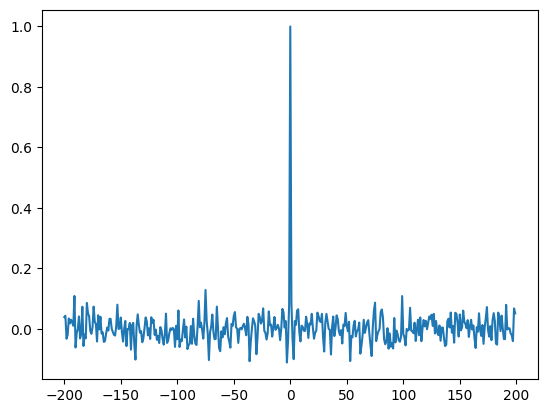

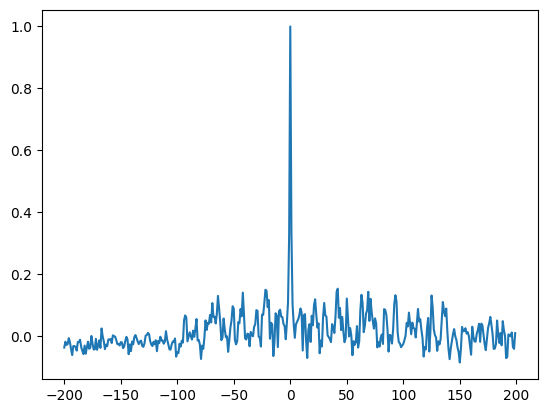

In [126]:
k = 200
m = np.arange(-k, k)
Rxx = []

for i in m:
    Rxx.append(AKF(y1_clean, i))
plt.plot(m, Rxx)
plt.show()

Rxx = []
for i in m:
    Rxx.append(AKF(y2_clean, i))
plt.plot(m, Rxx)
plt.show()

In [127]:
def SPM(X, k):
    # Оценка спектральной плотность мощности
    Ixx = 0
    delta = T / N

    Ixx_1 = 0
    Ixx_2 = 0

    for i in range(0, N):
        Ixx_1 += X[i] * np.cos((2 * np.pi * k * i) / N)
        Ixx_2 += X[i] * np.sin((2 * np.pi * k * i) / N)
    
    Ixx = delta / N * (Ixx_1 ** 2 + Ixx_2 ** 2)
    return Ixx
    

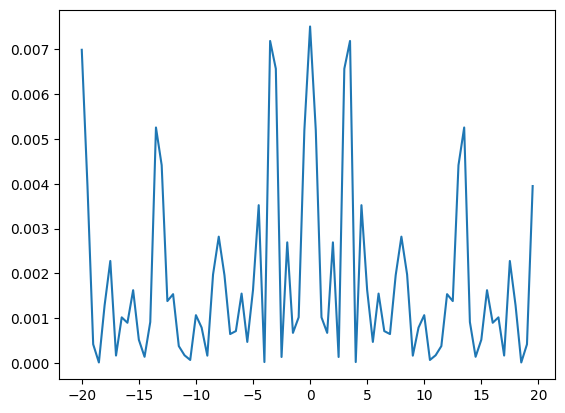

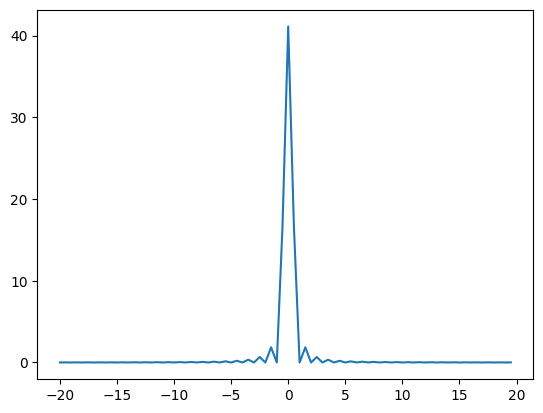

In [128]:
k = np.arange(-20, 20, 0.5)
f = k / T

Sxx = []

for i in k:
    Sxx.append(SPM(y1_clean, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

Sxx = []
for i in k:
    Sxx.append(SPM(y2_clean, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()